In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import model_selection, datasets
import joblib
import pickle

In [2]:
df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
df.head()

,path,type,diagnose
0,./Brain scans\Tumor\TRAIN\y0.jpg,brain,tumor
1,./Brain scans\Tumor\TRAIN\y1.jpg,brain,tumor
2,./Brain scans\Tumor\TRAIN\y10.jpg,brain,tumor
3,./Brain scans\Tumor\TRAIN\y100.jpg,brain,tumor
4,./Brain scans\Tumor\TRAIN\y101.jpg,brain,tumor


In [3]:
y_train = df['type']
y_test = test_df['type']

In [7]:
x_train = []
x_test = []

In [8]:
for path in df["path"]:
    x_train.append(cv2.resize(cv2.cvtColor(cv2.imread(path,0), cv2.COLOR_BGR2RGB), (300,300)))
for path in test_df["path"]:
    x_test.append(cv2.resize(cv2.cvtColor(cv2.imread(path,0), cv2.COLOR_BGR2RGB), (300,300)))

In [9]:
x_train = pd.Series(x_train)
x_test = pd.Series(x_test)

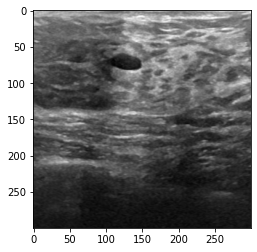

In [10]:
plt.imshow(x_train[1100])

In [19]:
orb = cv2.ORB_create(nfeatures = 0)
sift = cv2.SIFT.create()

In [12]:
def Feature_extractor(image, extractor):
    kp, des = extractor.detectAndCompute(image, None)
    return kp, des

In [20]:
features_list = []
for image in x_train:
    kp, des = Feature_extractor(image, sift)
    features_list.append((image,kp,des))

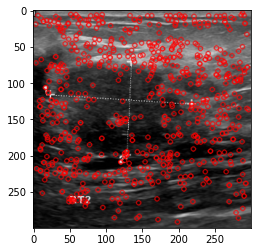

In [21]:
figure = cv2.drawKeypoints(features_list[1413][0], features_list[1413][1], None, color = (255,0,0), flags = 0)
plt.imshow(figure)
plt.show()

In [22]:
descriptors = features_list[0][2]
for image, kp, des in features_list[1:]:
    descriptors = np.vstack((descriptors, des))

In [23]:
k = 40
kmeans_model = KMeans(n_clusters = k)
kmeans_model.fit(descriptors)

KMeans(n_clusters=40)

In [135]:
filename = "Stage1BOW.joblib"
joblib.dump(kmeans_model, filename)

['Stage1BOW.joblib']

In [127]:
len(kmeans_model.cluster_centers_)

40

In [24]:
codebook = kmeans_model.cluster_centers_
codebook.shape

(40, 128)

In [25]:
def FreqVecCreator(features_list):
    visual_words = []
    for image, kp, des in features_list[:]:
        im_visual_words, distance = vq(des, codebook)
        visual_words.append(im_visual_words)
    frequency_vectors = []
    for img_visual_words in visual_words:
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)
    return np.stack(frequency_vectors)

In [26]:
new_df = pd.DataFrame(data = FreqVecCreator(features_list))
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,10.0,28.0,14.0,11.0,38.0,16.0,19.0,8.0,14.0,6.0,...,29.0,22.0,16.0,16.0,21.0,10.0,25.0,8.0,7.0,27.0
1,15.0,17.0,14.0,6.0,50.0,14.0,19.0,19.0,14.0,8.0,...,36.0,33.0,8.0,14.0,27.0,17.0,13.0,6.0,1.0,19.0
2,2.0,14.0,17.0,11.0,24.0,6.0,7.0,3.0,28.0,10.0,...,13.0,36.0,12.0,4.0,19.0,4.0,8.0,10.0,4.0,30.0
3,13.0,8.0,7.0,9.0,14.0,10.0,11.0,24.0,7.0,6.0,...,17.0,9.0,10.0,8.0,3.0,15.0,10.0,18.0,3.0,4.0
4,2.0,3.0,11.0,3.0,9.0,19.0,21.0,6.0,2.0,12.0,...,17.0,6.0,25.0,5.0,3.0,25.0,42.0,9.0,7.0,1.0


In [144]:
new_df.iloc[0]

0        -0.443091
1        -0.343679
2        -0.618452
3        -0.106518
4        -0.902894
5        -0.612421
6         -1.10799
7          0.91319
8        -0.875308
9          3.79151
10       -0.616169
11         1.22728
12       -0.611164
13         1.96072
14       -0.386521
15        -1.26851
16       -0.671501
17       -0.802024
18        -1.26337
19        -1.28061
20       -0.985531
21        -1.30609
22       -0.624513
23       -0.915794
24       -0.529068
25       -0.575872
26        0.606684
27      -0.0673805
28        -0.97624
29       -0.445467
30         1.83317
31       -0.547559
32       -0.693554
33        -1.21687
34       -0.282601
35        -1.03697
36       -0.307146
37        0.686064
38         1.15365
39       -0.224717
label        brain
Name: 818, dtype: object

In [27]:
new_df = (new_df - new_df.mean()) / new_df.std()
new_df['label'] = y_train
new_df = shuffle(new_df)

In [28]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
818,-0.443091,-0.343679,-0.618452,-0.106518,-0.902894,-0.612421,-1.107994,0.913190,-0.875308,3.791511,...,-0.547559,-0.693554,-1.216873,-0.282601,-1.036970,-0.307146,0.686064,1.153652,-0.224717,brain
1398,0.646376,-0.343679,-0.618452,-0.222480,-0.136148,-0.485921,0.255857,0.225504,-0.475724,0.875040,...,-0.971862,-0.135036,0.454726,-0.647647,-0.054559,-0.630487,-0.236513,0.336566,-0.639389,breast
1570,-0.694506,-0.788859,-0.368975,-0.744313,0.119434,-0.802172,0.028549,-0.844231,-0.542321,-0.208220,...,-0.462698,-0.569439,-0.783495,-0.830170,-0.459081,-0.792158,-0.051998,-0.071977,-1.157730,breast
1003,-0.694506,-0.744341,-0.701611,-0.396425,-1.073281,-0.928672,-0.880685,-0.844231,-0.941905,-0.458203,...,-0.547559,-0.941784,-0.721584,-0.875800,-0.516870,-1.115500,-0.697802,0.268476,-1.365066,breast
288,-0.359286,-0.566269,-0.285816,-0.802294,-0.221342,-1.118423,-0.937513,0.378323,-0.342529,-0.541531,...,-0.292976,-1.003842,-0.721584,-0.510755,-0.863603,0.258702,-0.605544,-0.957153,-0.328385,brain


In [29]:
X_Train = new_df.loc[:, new_df.columns != 'label']
Y_Train = new_df['label']

In [38]:
test_features_list = []
for image in x_test:
    kp, des = Feature_extractor(image, sift)
    test_features_list.append((image,kp,des))

In [40]:
new_test_df = pd.DataFrame(data = FreqVecCreator(test_features_list))

In [41]:
new_test_df = (new_test_df - new_test_df.mean()) / new_test_df.std()
new_test_df['label'] = y_test
new_test_df = shuffle(new_test_df)

In [42]:
X_Test = new_test_df.loc[:, new_test_df.columns != 'label']
Y_Test = new_test_df['label']

In [43]:
rst = RandomForestClassifier(n_estimators = 120, max_features = 10)
rst.fit(X_Train, Y_Train)
rst.score(X_Train,Y_Train)

1.0

In [44]:
rst_y_pred = rst.predict(X_Test)
accuracy_score(rst_y_pred,Y_Test)

0.9063545150501672

In [25]:
filename = "Stage1RandomForest.joblib"
joblib.dump(rst, filename)

['Stage1RandomForest.joblib']

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 160, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [27]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [28]:
rndfrst = RandomForestClassifier()

In [29]:
# rf_Grid = GridSearchCV(estimator = rndfrst, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [30]:
# rf_Grid.fit(X_Train, Y_Train)

In [31]:
# rf_Grid.best_params_

In [32]:
# rf_Grid.score(X_Train, Y_Train)

In [33]:
# rf_Grid.score(X_Test, Y_Test)

In [139]:
gbt = GradientBoostingClassifier(learning_rate = 0.9,n_estimators = 180)
gbt.fit(X_Train, Y_Train)
gbt.score(X_Train,Y_Train)

1.0

In [140]:
gbt_y_pred = gbt.predict(X_Test)
accuracy_score(gbt_y_pred,Y_Test)

0.9765886287625418

In [141]:
filename = "Stage1Gboost.joblib"
joblib.dump(gbt, filename)

['Stage1Gboost.joblib']

In [143]:
Y_Test

82      brain
146     brain
11      brain
298    breast
34      brain
        ...  
124     brain
196     brain
45      brain
1       brain
242    breast
Name: label, Length: 299, dtype: object

In [142]:
gbt_y_pred

array(['brain', 'brain', 'brain', 'breast', 'brain', 'brain', 'brain',
       'breast', 'brain', 'breast', 'brain', 'brain', 'brain', 'brain',
       'breast', 'brain', 'brain', 'brain', 'breast', 'brain', 'brain',
       'brain', 'brain', 'breast', 'brain', 'brain', 'breast', 'brain',
       'breast', 'brain', 'breast', 'brain', 'brain', 'brain', 'brain',
       'brain', 'breast', 'brain', 'brain', 'brain', 'brain', 'breast',
       'brain', 'breast', 'brain', 'brain', 'breast', 'brain', 'brain',
       'breast', 'brain', 'breast', 'brain', 'brain', 'brain', 'brain',
       'breast', 'brain', 'brain', 'brain', 'brain', 'brain', 'breast',
       'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain',
       'breast', 'brain', 'brain', 'brain', 'brain', 'breast', 'brain',
       'brain', 'brain', 'brain', 'breast', 'breast', 'brain', 'brain',
       'brain', 'brain', 'breast', 'brain', 'breast', 'breast', 'brain',
       'brain', 'breast', 'brain', 'brain', 'brain', 'breast', 'br

In [37]:
# gnb = GaussianNB()
# gnb.fit(X_Train, Y_Train)
# gnb.score(X_Train,Y_Train)

In [38]:
# gnb_y_pred = gnb.predict(X_Test)
# accuracy_score(gnb_y_pred,Y_Test)

In [39]:
# from sklearn.svm import SVC

In [40]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

In [41]:
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_Train, Y_Train)

In [42]:
# clf.score(X_Train,Y_Train)

In [43]:
# clf_y_pred = clf.predict(X_Test)
# accuracy_score(clf_y_pred,Y_Test)

In [47]:
from sklearn.neural_network import MLPClassifier

In [48]:
ann = MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(10,5), random_state=10,warm_start=True)

In [49]:
ann.fit(X_Train, Y_Train)
ann.score(X_Train,Y_Train)

1.0

In [50]:
ann_y_pred = ann.predict(X_Test)
accuracy_score(ann_y_pred,Y_Test)

0.9765886287625418

In [49]:
filename = "Stage1MLP.joblib"
joblib.dump(ann, filename)

['Stage1MLP.joblib']

In [50]:
ann = joblib.load("Stage1MLP.joblib")

In [51]:
ann_y_pred = ann.predict(X_Test)
accuracy_score(ann_y_pred,Y_Test)

0.9498327759197325

In [63]:
ada = AdaBoostClassifier()
ada.fit(X_Train, Y_Train)
ada.score(X_Train, Y_Train)

1.0

In [64]:
ada_y_pred = ada.predict(X_Test)
accuracy_score(ada_y_pred,Y_Test)

0.9163879598662207

In [85]:
rst = RandomForestClassifier(n_estimators = 80, max_features = 5)
rst.fit(X_Train, Y_Train)
rst.score(X_Train,Y_Train)

1.0

In [86]:
rst_y_pred = rst.predict(X_Test)
accuracy_score(rst_y_pred,Y_Test)

0.9331103678929766